### Tutorial 1: Clustering on 10X Genomics Visium DLPFC slices

In this tutorial, we will show how to use the stCAMBL model to perform spatial transcriptomic analysis of DLPFC slices to obtain cluster maps as well as UMAP . Relevant data can be obtained from github.

**Import the relevant python analysis package**

In [1]:
import scanpy as sc
import pandas as pd
from sklearn import metrics
import torch
import scipy
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')
import stCAMBL
import os
#Please change this path to your local R environment path
os.environ['R_HOME'] = '/data3/wkcui/env/anaconda3/envs/stCAMBL/lib/R'


/home/wkcui/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Read data and perform data preprocessing**

In [5]:
random_seed = 2050
stCAMBL.set_seed(random_seed)
device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
# You can change the dataset to other 12 DLPFC slices
dataset = '151510'
n_clusters = 5 if dataset in ['151669', '151670', '151671', '151672'] else 7
file_name = dataset
# Please change this path to your local data path
file_fold = '/data3/yfchen/stCAMBL/data/10X/' + file_name 
adata = sc.read_visium(file_fold, count_file=dataset+'_filtered_feature_bc_matrix.h5', load_images=True)
adata.var_names_make_unique()
df_meta = pd.read_csv(file_fold + '/metadata.tsv', sep='\t')
adata.obs['layer_guess'] = df_meta['layer_guess']
adata.layers['count'] = adata.X.toarray()
# Data preprocessing
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

if scipy.sparse.issparse(adata.X):
    adata.X = adata.X.toarray()

**Perform stCAMBL analysis**

In [6]:
from sklearn.decomposition import PCA
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)

adata.obsm['X_pca'] = adata_X
graph_dict = stCAMBL.graph_construction(adata, 12)
model = stCAMBL.stCAMBL(adata.obsm['X_pca'], graph_dict, device=device)
# Begin to train the model
model.train_model(epochs=300, dataset=dataset)
stCAMBL_feat, defeat, _, _, _ = model.process()
adata.obsm['emb'] = stCAMBL_feat

100%|██████████| 300/300 [01:00<00:00,  4.97it/s]


**Calculate ARI**

In [8]:
radius = 50
tool = 'mclust' 
from stCAMBL.clust_func import clustering
clustering(adata, n_clusters, radius=radius, method=tool, refinement=True)
sub_adata = adata[~pd.isnull(adata.obs['layer_guess'])]
# Calculate ARI
ARI = metrics.adjusted_rand_score(sub_adata.obs['layer_guess'], sub_adata.obs['domain'])
adata.uns['ARI'] = ARI
print('Dataset:', dataset)
print('ARI:', ARI)   

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Dataset: 151510
ARI: 0.7186841617815894


**Draw cluster map and UMAP**

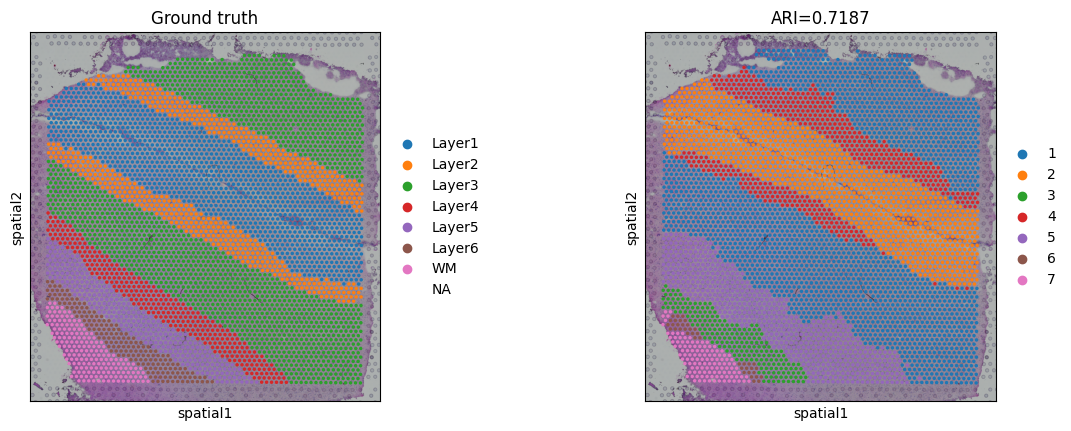

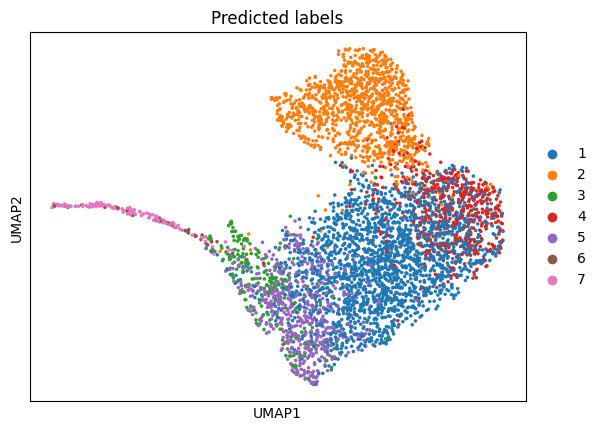

In [9]:
# plotting spatial clustering result
sc.pl.spatial(adata,
            img_key="hires",
            color=["layer_guess", "domain"],
            title=["Ground truth", "ARI=%.4f"%ARI],
            show=True)


# plotting predicted labels by UMAP
sc.pp.neighbors(adata, use_rep='emb_pca', n_neighbors=10)
sc.tl.umap(adata)
sc.pl.umap(adata, color='domain', title=['Predicted labels'], show=True)